# Distinguishing between subreddits: "One Punch Man" VS "Death Note"

## Problem Statement

A devious troll has hacked Reddit! They posted the following:

> When an anime character can simply kill opponents in one punch or by writing a name in a notebook, the plot quickly becomes stale and boring! Such shows become indistinguishable from each other. As proof, I've randomly swapped posts between r/OnePunchMan and r/deathnote - not that anyone could tell the difference, since there is virtually no difference between these shows.  
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - *Boop*

Fortunately, we've recently stored posts from both r/OnePunchMan and r/deathnote.   

Using Natural Language Processing, we should be able to develop a classification model (Logistic Regression, K-nearest Neighbors, Naive Bayes, etc.) to accurately predict which subreddit a post belongs to based on its title alone. Accuracy will be used to assess model effectiveness.

If an effective model can be found, we can undo the havoc caused by the hacker, while also disproving their belief these shows are the same! __"One Punch Man" and "Death Note" fans on Reddit__ will be able to enjoy their online spaces in peace and __Reddit developers__ would have a potential model to use, should such an incident were to happen again.

## Executive Summary
When we started this project, we assumed the difference between the r/deathnote and r/OnePunchMan would be simply reliant on words related to their unique named characters and places as well as topics, such as "death" in Death Note. During the EDA and afterwards, while investigating my final model, it was clear the data had more going on than we gave it credit for. Of course there were tight associations with the named characters, but we did not anticipate seeing temporal features. Likewise, there were some words that had a strong connection with r/deathnote that we still cannot explain.

Given the vast number of classification models and combining them with 2 different vectorizors quickly got out of hand. This forced me to streamline the model exploration process and develop a deliberate and repeatable workflow. We first attempted to resolve the issue by creating a complex `EnsembleGridSearchCV`, which worked much like `GridSearchCV`, but for  multiple models. It took in a list of transformers and estimators as well as a dictionary of parameters and did a grid search across all transformer + estimator combinations, returning a `VotingClassifier` combining all of the optimized models into one model. This was ultimately scrapped for being overly complicated (not to mention it took too long to process!).

We settled for a more lightweight solution in creating the `AdvancedGridSearch` function to simply handle a single `Pipeline` estimator and optimize for it.  

We were also surprised by the high model accuracy we began seeing right away. The distinct nature of the subreddits were clearly strong, but the reason for that distinction had little to do with the shows themselves, but rather an indirect indicator of whether the show was currently in production or not (One Punch Man only recently ended its 2nd season, while Death Note was finished years ago). 

Also surprising was the optimum model was not a typically high performing one (such as an ensemble). We learned that, as great as the ensemble class of models are, there is still benefit in exploring simplier models first. It really is better to start exploring the data with a basic model and use those findings to make informed decisions in progressing onto more complex and fine-tuned models. After seeing such high accuracy with the Logistic Regression or even the Naive Bayes models, there really was little rational to continue exploring more complicated models - especially those designed to address problems of overfitting or high variance (something we were not seeing!).

## Table of Contents

1. [Gathering the Data](#Gathering-the-Data) 
1. [Loading Libraries and Data](#Loading-Libraries-and-Data)
1. [Data Cleaning](#Data-Cleaning) 
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis) 
1. [Preprocessing corpus](#Preprocessing-corpus)
1. [Visualizing preprocessed words](#Visualizing-preprocessed-words)
1. [Model Preparation](#Model-Preparation) 
1. [Modeling](#Modeling) 
1. [Model Selection](#Model-Selection) 
1. [Model Evaluation](#Model-Evaluation) 
1. [Conclusion](#Conclusion)
1. [Assumptions](#Assumptions)
1. [Recommendations](#Recommendations)
1. [References](#References)

## Gathering the Data
The data obtained come from the [OnePunchMan](https://www.reddit.com/r/OnePunchMan/) and [deathnote](https://www.reddit.com/r/deathnote/) subreddits from the [Reddit API](https://www.reddit.com/dev/api/).

Given the time-dependent nature of pulling data from a "live" API, it is relevent to mention these data were gathered on or about Wednesday July 10th, 2019.  

Please see the associated `gathering_data.py` file for the data collection process.

## Loading Libraries and Data

In [155]:
import re
import emoji #😲
import toyplot.data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from math import floor
from types import MethodType

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import TransformerMixin

warnings.filterwarnings("ignore") #Shhhhhhh

RANDOM_STATE = 525600 # "Seasons of Love"
np.random.seed(RANDOM_STATE)

In [69]:
data_file = "../data/subreddit_data.csv"
df = pd.read_csv(data_file)

In [70]:
df.head(3)

,subreddit,title
0,0,Totally accurate
1,0,I like this picture of L a lot
2,0,So idk how many of you guys have seen the glor...


## Data Cleaning

Using the `gathering_data.py` file, duplicate entries are removed and the target variable, "subreddit", represents the two subreddits as follows:
- Death Note = 0
- One Punch Man = 1  

In [71]:
# checking for any remaining "title" duplicates
df["title"].describe()

count                                                  1572
unique                                                 1572
top       [Latest Episode] Moment from last episode was ...
freq                                                      1
Name: title, dtype: object

There are no duplicate titles.

### Handling Null Values

In [72]:
df.isnull().sum()

subreddit    0
title        0
dtype: int64

No null values were found. This is a complete dataset.

## Exploratory Data Analysis
Given the text data, we will use Natural Language Processing to explore any trends, outliers, or any issues that may come up during modeling.

### Class balance

In [73]:
df.shape

(1572, 2)

In [74]:
df["subreddit"].value_counts(normalize = True)

0    0.613232
1    0.386768
Name: subreddit, dtype: float64

The data has 1572 observations with roughly 39% belonging to the "positive" target (r/OnePunchMan) and roughly 61% belonging to the "negative" target (r/deathnote).

There is a slight class unbalance, but nothing too substantial. During modeling, we may have to keep this concern in mind.

### Visualizing words
Observing the frequency of words is a good first step in exploring common trends in the data. we'll create a simple bar chart to help visualize word frequency.

In [75]:
all_words = pd.DataFrame(sum(list(df["title"].map(lambda x: x.split())), []))
count_thresh = 75
word_counts = all_words[0].value_counts()
df_word_counts = pd.DataFrame(word_counts[word_counts >= count_thresh])
size = 18

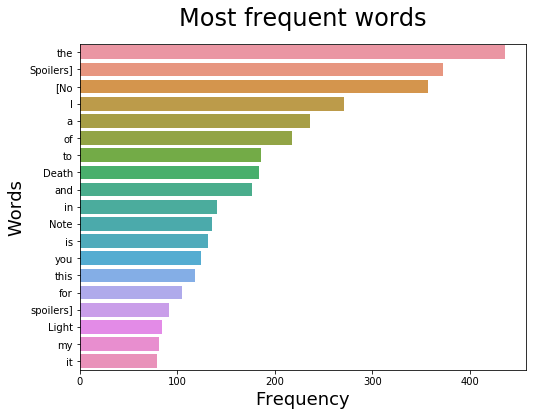

In [76]:
plt.figure(figsize = (8,6))
b = sns.barplot(x = df_word_counts[0], y = df_word_counts.index, orient = "h")
b.set_title("Most frequent words", fontsize = size * 4/3, pad = size)
b.set_xlabel("Frequency", fontsize = size)
b.set_ylabel("Words", fontsize = size);

Unsurprisingly, we can see common words, such as "the" and "a", occur at a high frequency in this unprocessed corpus. Given the commonality of such words, it would be reasonable to assume they do not contribute much meaningful information overall, and can be removed without affecting the overal sentiment of each document.

Likewise, we can see the inclusion of special characters, such as the square brackets seen with "Spoilers]" and "[No". We feel confident in assuming these special non-alphabetic characters can also be safely removed without significantly altering the sentiment of each document.

_These assumptions must be kept in consideration when looking at the model, however, as there is a chance some of the classification power may be lost by removing these text features._

## Emojis 😋

In [77]:
df["title"].sort_values(ascending = False)[:5]

37       🧐
944      😬
309    😂 😂
910      💓
832     👌🏻
Name: title, dtype: object

Although rare, we can see emoticons may be present in some documents.  
We have choose not to remove these data points, as emoticons do convey sentiment, and should therefore remain included.

During tokenization, we'll account for emojis using the `emoji` python package.

## Creating custom processing variables

### Stop Words
There are lists of english "stop words" we could use for preprocessing the documents. After some brief exploration, it was clear the standard list of "stop words" was too exhaustive and was removing many key features of the data leading to poor model performance. We've opted to create an abridged customized "stop words" list.

In [78]:
custom_stop_words = [
    'what', 'is', 'the', 'on', 'how', 'my', 'would', 'it', 'for', 'in',
    'be', 'me', 'if', 'so', 'and', 'to', 'from', 'with', 'do', 'of',
    'think', 'you', 'that', 'anim', 'one', 'manga','this',
    'about', 'was', 'have', 'whi', 'can', 'all', 'by', 'but'
]

### Handling Emojis
The following preprocessing function will be used by vectorizers to convert document emojies into raw text

In [79]:
def custom_preprocess(string):
    string = emoji.demojize(string.lower(), delimiters = (" ", " ")) # convert emojis into strings
    string = string.replace("spoilers","spoiler") # stemmer was not converting properly this important word
    return string 

In [80]:
# testing `custom_preprocess` function
custom_preprocess("😎")

' smiling_face_with_sunglasses '

### Tokenizer RegEx
Given our subject knowledge, we've found an issue in the data that needs to be addressed.  

In the "Death Note" anime, there is a significant character simply named 'L'. The vectorizers we're using to transform the corpus automatically ignore single-letter words. In order to properly expose this significant data point, we will modify how single letters are treated during our preprocessing step by creating a custom tokenizer using regular expressions.

In [81]:
# RegEx all words with at least 2 letters OR the letter "L"
include_singles = r"\w{2,}|[lL]"

## Stemming
Often, the Natural Languange Processing will include some way of converting words to their root or stem as a way of combining similar sentiments. We've chosen to use a stemming technique known as [Snowball Stemmer](http://www.nltk.org/howto/stem.html), which is considered to perform better than the Porter Stemmer.

In [82]:
stemmer = SnowballStemmer("english")
df["title"] = df["title"].apply(lambda words: " ".join([stemmer.stem(word) for word in words.split()]))
# NOTE: .stem() works on individual tokens and NOT the entire document, hence the need to split

## Preprocessing corpus
For this Natural Language Processing problem, we'll explore two methods for vectorizing textual data:

- __CountVectorizer__ offers an intuitive count of each word by document  
- __TfidfVectorizer__ penalizes word frequency across the entire corpus

In [83]:
vectorization_params = {
    "stop_words"   : custom_stop_words,
    "token_pattern": include_singles, 
    "preprocessor" : custom_preprocess,
    "strip_accents": "ascii"
}

# establishing these now for later model preprocessing
cvec = CountVectorizer(**vectorization_params)
tfidf = TfidfVectorizer(**vectorization_params)

## Visualizing preprocessed words
Viewing the preprocessed corpus can now give us a better idea of the more meaningful parts of the data are as well as some insight into innate differences between the two subreddits.

_NOTE: Only CountVectorizer is being used here_

In [84]:
# using different CountVectorizer as not to confuse with one used for models
prep_cvec = CountVectorizer(**vectorization_params)
feature_counts = pd.DataFrame(data = prep_cvec.fit_transform(df["title"]).toarray(), columns = prep_cvec.get_feature_names()).sum()
feature_counts.index = ["L" if i == "l" else i for i in feature_counts.index]
df_filtered_word_counts = pd.DataFrame(feature_counts.sort_values(ascending = False)[:10])

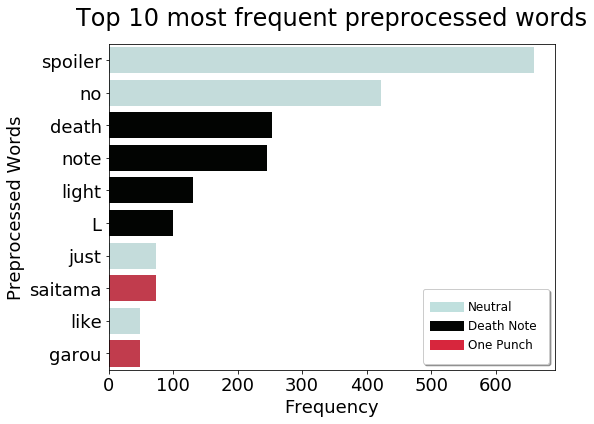

In [87]:
size = 18

# establishing custom color variables
neutral, death, punch = "#C0E0DE", "#020402", "#D7263D"
word_pattern = [neutral, neutral, death, death, death, death, neutral, punch, neutral, punch]
plt.figure(figsize = (8,6))
b = sns.barplot(x = df_filtered_word_counts[0], y = df_filtered_word_counts.index, orient = "h", palette = word_pattern)

b.set_title("Top 10 most frequent preprocessed words", fontsize = size * 4/3, pad = size)
b.tick_params(labelsize = size)
b.set_xlabel("Frequency", fontsize = size)
b.set_ylabel("Preprocessed Words", fontsize = size);
leg = b.legend(labels=["Neutral","Death Note","One Punch"],fontsize="large",fancybox=True, framealpha=1, shadow=True, borderpad=1)
leg_lines = leg.get_lines()
leg_lines[0].set_color(neutral);leg_lines[1].set_color(death);leg_lines[2].set_color(punch)
for line in leg_lines:
    line.set_linewidth(10)

*NOTE: I've added a subjective color distinction to denote the words I feel are most closely associated with either subreddit*  
 
Looking at the most frequent words, we can see "no" and "spoilers" are quite common. This is not entirely surprising, considering the subject matter - "no spoilers" is a common signal to readers to inform them a post's content does not give away any important plot details.

"death", "note", "light", and "L" are all relevant to Death Note, so these also make intuitive sense.  

Surprisingly, One Punch Man related words were not as common as Death Note related words - "saitama" and "garou" are the main protagonist and antagonist from One Punch Man.  

### Most frequent words by subreddit
To get a better understanding of unique characteristics, we'll explore words frequency for each subreddit.

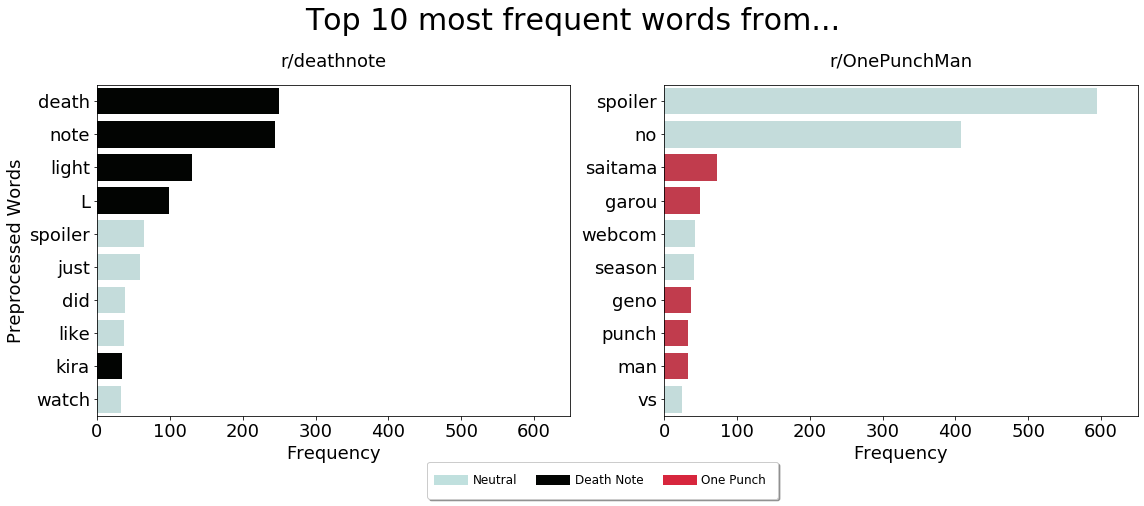

In [58]:
plt.figure(figsize = (16,6))

# custom coloring scheme
word_patterns = [
    [death, death, death, death, neutral, neutral, neutral, neutral, death, neutral],
    [neutral, neutral, punch, punch, neutral, neutral, punch, punch, punch, neutral]
]
names = ["r/deathnote","r/OnePunchMan"]

for i in range(2):
    feature_counts = pd.DataFrame(data = prep_cvec.fit_transform(df[df["subreddit"]==i]["title"]).toarray(), columns = prep_cvec.get_feature_names()).sum()
    feature_counts.index = ["L" if i == "l" else i for i in feature_counts.index]
    df_filtered_word_counts = pd.DataFrame(feature_counts.sort_values(ascending = False)[:10])
    word_pattern = word_patterns[i]
    plt.subplot(1,2,i+1)
    b = sns.barplot(x = df_filtered_word_counts[0], y = df_filtered_word_counts.index, orient = "h", palette = word_pattern)

    b.set_title(names[i], fontsize = size, pad = size)
    b.tick_params(labelsize = size)
    b.set_xlabel("Frequency", fontsize = size)
    b.set_xlim(0,650)
    if i == 0:
        b.set_ylabel("Preprocessed Words", fontsize = size)
plt.suptitle("Top 10 most frequent words from...", fontsize = size * 5/3, y = 1.08)
plt.tight_layout()
leg = plt.legend(labels=["Neutral","Death Note","One Punch"], loc = (-.5,-.25),ncol = 3,fontsize="large",fancybox=True, framealpha=1, shadow=True, borderpad=1)
leg_lines = leg.get_lines()
leg_lines[0].set_color(neutral);leg_lines[1].set_color(death);leg_lines[2].set_color(punch)
for line in leg_lines:
    line.set_linewidth(10)

Interestingly, the most common words from r/deathnote directly relate to the "Death Note" anime, while the most common words from r/OnePunchMan are more general to shows recently still in production, "spoiler" and "no (spoiler)".  

**This suggests our models will likely associate neutral words like "spoilers" and "no" directly to the One Punch Man reddit.**

### Visualizing word frequency by subreddit

In [60]:
# Plotting prep cell
import matplotlib
from matplotlib.lines import Line2D

feature_count_cutoff = 2
feature_counts = pd.DataFrame(data = prep_cvec.fit_transform(df["title"]).toarray(), columns = prep_cvec.get_feature_names()).sum()
count_index = feature_counts[feature_counts>=feature_count_cutoff].index
plot_data = pd.DataFrame(index = count_index)
plot_data["weight"] = feature_counts[count_index]
opm_count_data = pd.DataFrame(data = prep_cvec.fit_transform(df[df["subreddit"]==1]["title"]).toarray(), columns = prep_cvec.get_feature_names()).sum()
opm_count_data = opm_count_data[count_index].fillna(0)
plot_data["from_opm"] = np.log(opm_count_data[count_index] + 1)
dn_count_data = pd.DataFrame(data = prep_cvec.fit_transform(df[df["subreddit"]==0]["title"]).toarray(), columns = prep_cvec.get_feature_names()).sum()
dn_count_data = dn_count_data[count_index].fillna(0)
plot_data["from_dn"] = np.log(dn_count_data + 1)
diff = plot_data["from_opm"] - plot_data["from_dn"]
plot_data["hue"] = diff
count_max = plot_data["weight"].max()
count_min = plot_data["weight"].min()
cMap = matplotlib.cm.get_cmap("PRGn")
legend_elements = [
    Line2D([0], [0], marker='o', color="w", markerfacecolor="g", label='100', markersize=75 * .13), # I'm actually just making these scales up such that they look like they match!
    Line2D([0], [0], marker='o', color="w", markerfacecolor="g", label='200', markersize=125 * .13),
    Line2D([0], [0], marker='o', color="w", markerfacecolor="g", label='500', markersize=200 * .13)
]
offset = 0.15
top_words = list(set(list(opm_count_data.sort_values(ascending=False)[:4].index) + list(dn_count_data.sort_values(ascending=False)[:5].index)))

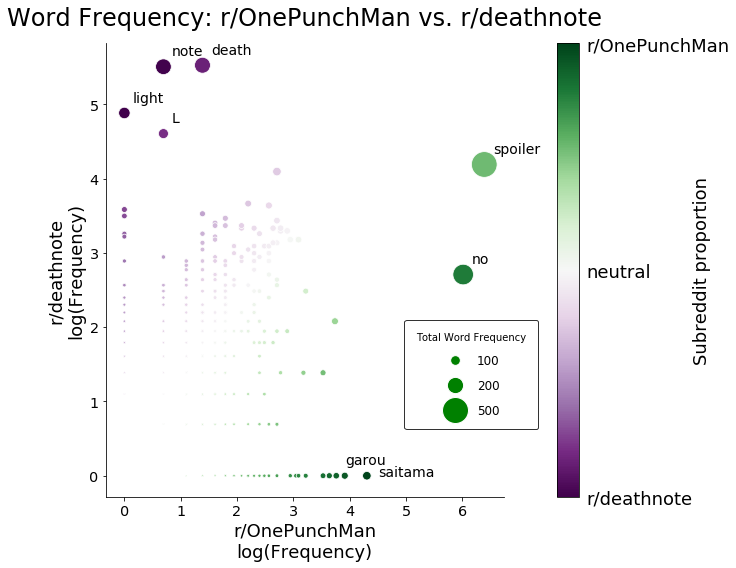

In [61]:
# Plotting cell
g = sns.relplot(x="from_opm", y="from_dn", size="weight",
            sizes=(count_min, count_max), alpha=1, palette="PRGn", hue="hue", 
            hue_norm= (plot_data["hue"].min(),plot_data["hue"].max()),
            height=8, aspect=1.2, data=plot_data, legend = False)
g.despine(right=True)
plt.legend(title = "Total Word Frequency",handles = legend_elements, loc=(.75,.15), 
           facecolor = None,edgecolor = "k", frameon = True,borderpad = 1,labelspacing = 1,fontsize = size * 2/3)
cm = plt.pcolor([[-1,1],[-1,1]], cmap=cMap, visible = False)
cbar = plt.colorbar(cm, orientation='vertical', ticks=[-1, 0, 1], pad=.1)
cbar.ax.tick_params(bottom=False, top=False, left=False, right=False)
cbar.ax.set_yticklabels(['r/deathnote', 'neutral', 'r/OnePunchMan'], fontsize = size)
cbar.set_label('Subreddit proportion', fontsize = size, labelpad = -size*2)
plt.title("Word Frequency: r/OnePunchMan vs. r/deathnote", fontsize = size * 4/3, pad = size)
plt.xlabel("r/OnePunchMan\nlog(Frequency)", fontsize = size)
plt.ylabel("r/deathnote\nlog(Frequency)", fontsize = size)
plt.tick_params(labelsize = size * 4/5)
for word in top_words:
    try:
        x = plot_data["from_opm"][word]
    except:
        x = 0
    try:
        y = plot_data["from_dn"][word]
    except:
        y = 0
    if word == "saitama": # custom word placement
        x += .05
        y -= .15
    elif word == "garou": # custom word placement
        x -= .15
    elif word == "l": # custom word placement
        word = "L"
    plt.text(x + offset, y + offset, word, horizontalalignment='left', size=14, color='black')
plt.tight_layout()

The above graph shows the frequency of words of r/OnePunchMan vs. r/deathnote. The color of each point denotes the relative proportion of a given subreddit. The customized list of stop words were created using words with the highest frequency, but showing little distinction between the subreddits.

__The data clearly shows the frequency of some words are distinct to each subreddit.__ Therefore, we are confident an effective model can be created to distinguish between the subreddits and address the problem.

## Model Preparation

Before we begin modeling, we created a workflow and helper functions to streamline and standardize the process of fitting, assessing, and ultimately selecting the best model for production.

### Model Workflow:
In order to streamline the process of discovering an optimum model, the following worklow was used:

1. Establish a baseline for model accuracy
2. For every model:
    1. Create pipeline using:
        - 1 x Transformer (CountVectorizer, TfidfVectorizer*)  
        - 1 x Model (LogisticRegression, KNN, etc.)
    2. AdvancedGridSearch:  
        - Train/Test split
        - GridSearchCV to discover “best” parameters for model
        - Use ROC AUC to discover optimum classification threshold
        - Score model accuracy using threshold to predict on testing dataset
3. Assess all models using accuracy on testing dataset
    1. Only models well above the baseline will be considers
    2. The model with the highest accuracy is chosen for production

In [62]:
X = df["title"]
y = df["subreddit"]

In [93]:
# Take from: https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr - (1 - fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    return roc_t['threshold']

### `AdvancedGridSearch`
We created the `AdvancedGridSearch` function as a way to simplify the modeling process and abstract many of the nuances of optimizing any given classification model.  

One key feature of `AdvancedGridSearch` is the addition of the `.predict_with_thresh()` method, which uses the ROC AUC to determine the optimum classification threshold and uses that threshold to better predict values. The `.predict_with_thresh()` method is added to the `GridSearchCV` object, which is returned by the function. 

In [166]:
def AdvancedGridSearch(estimator, params, X, y, random_state = RANDOM_STATE, verbose = False):
    '''
    Conducts a grid search of the given estimator with the given parameters using the
    given data_list. 
    
    Effectively this function serves as a wrapper for GridSearchCV with
    some additional functionality, optimizing for accuracy by defualt.
    
    After fitting, the optimum classifier threshold is determined using the ROC AUC.
    The GridSearchCV object is returned with a new .predict_with_thresh() method, which
    can be used to predict values using the optimum classifier threshold (instead of the
    default .5).
    
    params:
        estimator (BaseEstimator) : sklearn estimator
        params (dict)             : GridSearchCV param_grid
        X (Series)                : Pandas Series feature dataset
        y (Series)                : Pandas Series target dataset
        random_state              : random seed
        verbose (bool)            : flag for verbosity (default: False)
    
    return:
        GridSearchCV
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, stratify = y)
    
    # finding optimal params and model
    gs = GridSearchCV(estimator, param_grid = params, cv = 3)
    gs.fit(X_train, y_train)
    
    # finding optimal classifier threshold
    probs = [i[1] for i in gs.predict_proba(X)]
    optimum_thresh = Find_Optimal_Cutoff(y, probs)
    
    # adding `optimum_thresh_` as relevant attribute for use
    setattr(gs, 'optimum_thresh_', optimum_thresh)

    # adding new method to predicting method using optimal threshold
    def predict_with_thresh(self, df):
        return pd.Series([int(i[1] >= self.optimum_thresh_) for i in self.predict_proba(df)])
    gs.predict_with_thresh = MethodType(predict_with_thresh, gs)
    
    # using custom scoring function for cross validation (need to circumvent use of base estimator)
    def cross_val_scorer(_, X, y):
        preds = gs.predict_with_thresh(X)
        return accuracy_score(preds, y)

    if verbose:
        # train score
        train_preds = gs.predict_with_thresh(X_train)
        print("Train Accuracy:", accuracy_score(train_preds, y_train))
    
        # test score
        test_preds = gs.predict_with_thresh(X_test)
        print("Test Accuracy:", accuracy_score(test_preds, y_test))
        
        # cross val score
        print("Cross Val Accuracy:", cross_val_score(estimator, X, y, scoring = cross_val_scorer, cv = 5).mean())
        print("Optimum classification threshold: {}".format(optimum_thresh.to_string(index = False)))
    
    # returns model that handles predictions using optimum threshold 
    return gs

## Modeling

### Dummy (baseline) Model

In [167]:
dummy = AdvancedGridSearch(DummyClassifier("most_frequent"), {}, X, y, verbose = True)

Train Accuracy: 0.6132315521628499
Test Accuracy: 0.6132315521628499
Cross Val Accuracy: 0.6132322313214033
Optimum classification threshold:  1.0


Given the majority of the data is from the Death Note subreddit, the baseline model is simply to always assume this outcome - yeilding a ~61% accuracy.  

We can conclude any model that can perform above 61% accuracy is a better model by comparison.

### cvec + LogReg

In [168]:
cvec_logReg_pipe_list = [
    ("cvec", cvec),
    ("logReg", LogisticRegression())
]
cvec_logReg_params = {
    'cvec__max_features': [800],
    'cvec__min_df': [5],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,2)]
}

model_cvec_logReg = AdvancedGridSearch(Pipeline(cvec_logReg_pipe_list), cvec_logReg_params, X, y, verbose = True)

Train Accuracy: 0.9779474130619169
Test Accuracy: 0.9669211195928753
Cross Val Accuracy: 0.9751895662723689
Optimum classification threshold:  0.474615


The CountVectorizer (CVEC) and Logistic Regression model works well to distinguish between the subreddits.  
__This first model is already significantly more accurate than the baseline, making is a potential candidate for production.__

As we continue to explore other models, having 2 transformation components can become cumbersome, since we'll have to consider each model twice. After some experimenting, we'll want to make a final decision on which tokenizer to settle on.

### tfidf + LogReg

In [169]:
tfidf_logReg_pipe_list = [
    ("tfidf", tfidf),
    ("logReg", LogisticRegression())
]
tfidf_logReg_params = {
    'tfidf__max_features': [1300],
    'tfidf__min_df': [12],
    'tfidf__max_df': [.8],
    'tfidf__ngram_range': [(1,1)]
}

model_tfidf_logReg = AdvancedGridSearch(Pipeline(tfidf_logReg_pipe_list), tfidf_logReg_params, X, y, verbose = True)

Train Accuracy: 0.9728583545377438
Test Accuracy: 0.9592875318066157
Cross Val Accuracy: 0.9694631483166514
Optimum classification threshold:  0.415592


We see a comparable performance for the TfidfVectorizer and Logistic Regression.
However, the optimal hyperparameters suggest a less elegant model. We see:
1. The number of maximum features is higher, suggesting a higher dependence on sparce features
2. The 1-gram tokens used in this model, as opposed to the 1 & 2-gram used in the previous model, suggests this model will not be able to pick up more complex and informative sentiments.

The Logistic Regression classifier has shown itself to perform well. Perhaps using a K-nearest Neighbors (KNN) model will be more accurate.

### cvec + knn

In [170]:
cvec_knn_pipe_list = [
    ("cvec", cvec),
    ("knn", KNeighborsClassifier())
]
cvec_knn_params = {
    'cvec__max_features': [1500],
    'cvec__min_df': [12],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,1)],
    'knn__n_neighbors' : [6],
    'knn__weights' : ["distance"],
    'knn__p': [1]
}
model_cvec_knn = AdvancedGridSearch(Pipeline(cvec_knn_pipe_list), cvec_knn_params, X, y, verbose = True)

Train Accuracy: 0.9855810008481765
Test Accuracy: 0.9567430025445293
Cross Val Accuracy: 0.9783722576079263
Optimum classification threshold:  0.666667


The CVEC and KNN model has a weaker performance compared to the Logistic Regression. Additionally, the optimized parameters suggest this model is simple and also less likely to pick up on more complex word interactions.

### tfidf + knn

In [171]:
tfidf_knn_pipe_list = [
    ("tfidf",tfidf),
    ("knn", KNeighborsClassifier())
]
tfidf_knn_params = {
    'tfidf__max_features': [1000],
    'tfidf__min_df': [20],
    'tfidf__max_df': [.8],
    'tfidf__ngram_range': [(1,2)],
    'knn__n_neighbors' : [5],
    'knn__weights' : ["distance"],
    'knn__p': [1],
}
model_tfidf_knn = AdvancedGridSearch(Pipeline(tfidf_knn_pipe_list), tfidf_knn_params, X, y, verbose = True)

Train Accuracy: 0.9754028837998303
Test Accuracy: 0.9541984732824428
Cross Val Accuracy: 0.9700920028308563
Optimum classification threshold:  0.2


Interestingly, the TfidfVectorizer and KNN was less accurate then the CVEC + KNN. The optimized hyperparameters finally show a more elegant model, but is ultimately unsuccessful compared to earlier models. 

_NOTE: After some other trails exploring models, it became clear the TFIDF transformer was not performing as well as CVEC. From this point on, I'll only use the CVEC transformer._

### cvec + naive bayes (multinomial)

In [172]:
cvec_multNB_pipe_list = [
    ("cvec", cvec),
    ("mult", MultinomialNB())
]
cvec_multNB_params = {
    'cvec__max_features': [250],
    'cvec__min_df': [7],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,3)]
}

model_cvec_multNB = AdvancedGridSearch(Pipeline(cvec_multNB_pipe_list), cvec_multNB_params, X, y, verbose = True)

Train Accuracy: 0.9686174724342663
Test Accuracy: 0.9669211195928753
Cross Val Accuracy: 0.9681831968456173
Optimum classification threshold:  0.658594


The CVEC + Multinomial Naive Bayes (MultNB) model is the most accurate so far. Given it's restrictive maximum of 250 features, we also see the first model using tri-grams. Together, these parameters allow this model to be more sensative to sentiment.

### cvec + naive bayes (guassian)
We encountered an issue with the Guassian model, which was not accepting the sparse matrix from the tokenizer.  
We created a "middle-man" transformer, DenseTransformer, to convert the tokenizer's output to a dense matrix and pass that to the Guassian model.

[source](https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required)

In [173]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [174]:
cvec_guasNB_pipe_list = [
    ("cvec", cvec),
    ("_",DenseTransformer()),
    ("guas", GaussianNB())
]
cvec_guasNB_params = {
    'cvec__max_features': [300],
    'cvec__min_df': [12],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,3)]
}

model_cvec_guasNB = AdvancedGridSearch(Pipeline(cvec_guasNB_pipe_list), cvec_guasNB_params, X, y, verbose = True)

Train Accuracy: 0.9414758269720102
Test Accuracy: 0.926208651399491
Cross Val Accuracy: 0.9376544333232232
Optimum classification threshold:  9.611214e-26


Despite having a similar methodology and more sensative parameters to the MultNB, the CVEC + Guassian Naive Bayes model performs the worst of all models so far.

It's possible the use of decision trees could improve the accuracy seen in the CVEC + MultNB model, the most accurate model so far.

### cvec + DecisionTree

In [175]:
cvec_tree_pipe_list = [
    ("cvec",cvec),
    ("tree", DecisionTreeClassifier())
]
cvec_tree_params = {
    'cvec__max_features': [1000],
    'cvec__min_df': [15],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,2)],
    "tree__max_depth":[20],
    "tree__min_samples_leaf":[1],
    "tree__min_samples_split":[3],
}

model_cvec_tree = AdvancedGridSearch(Pipeline(cvec_tree_pipe_list), cvec_tree_params, X, y, verbose = True)

Train Accuracy: 0.9787955894826124
Test Accuracy: 0.9567430025445293
Cross Val Accuracy: 0.9732726721261754
Optimum classification threshold:  0.5


The CVEC + Decision Tree model does perform well and appears somewhat sensative to sentiment, but falls short of the best model so far.

Using a bagging model may improve on the Decision Tree accuracy, though there is little benefit as there is only so much bias/variance tradeoff possible.

### cvec + Bagging/DecisionTree

In [176]:
cvec_bag_tree_pipe_list = [
    ("cvec",cvec),
    ("bag", BaggingClassifier(DecisionTreeClassifier(), n_jobs = -1))
]
cvec_bag_tree_params = {
    'cvec__max_features': [100],
    'cvec__min_df': [5],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,3)],
    "bag__n_estimators" : [30],
    "bag__base_estimator__max_depth":[20],
    "bag__base_estimator__min_samples_leaf":[1],
    "bag__base_estimator__min_samples_split":[3],
}

model_cvec_bag_tree = AdvancedGridSearch(Pipeline(cvec_bag_tree_pipe_list), cvec_bag_tree_params, X, y, verbose = True)

Train Accuracy: 0.9830364715860899
Test Accuracy: 0.9592875318066157
Cross Val Accuracy: 0.9770963502173693
Optimum classification threshold:  0.469239


Interstingly, the CVEC + Bagging with Decision Tree model did not perform better than the basic Decision Tree. However, it should be noted this model is much more sensative to sentiment, using tri-grams and the most restrictive maximun number of features yet.

Perhaps using a Random Forest model can extract more accuracy.

### cvec + RandomForest

In [177]:
cvec_rf_pipe_list = [
    ("cvec",cvec),
    ("rf", RandomForestClassifier())
]

cvec_rf_params = {
    'cvec__max_features': [100],
    'cvec__min_df': [10],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,2)],
    "rf__n_estimators" : [75],
    "rf__max_depth" : [8],
    "rf__min_samples_leaf" : [1],
    "rf__min_samples_split" : [3]
}

model_cvec_rf = AdvancedGridSearch(Pipeline(cvec_rf_pipe_list), cvec_rf_params, X, y, verbose = True)

Train Accuracy: 0.9720101781170484
Test Accuracy: 0.9643765903307888
Cross Val Accuracy: 0.9700960469113336
Optimum classification threshold:  0.516461


We do ultimately see and improvement using CVEC + Random Forst, however the increase is not significant enough to overthrow the CVEC + MultNB model. Interestingly, we see a restrictive 100 maximum features and bi-grams as optimal hyperparameters.

Our last attempts to improve accuracy rely in Boosting models, which tend to perform well.

### cvec + GradientBoostingClassifier

In [178]:
cvec_gb_pipe_list = [
    ("cvec",cvec),
    ("gb", GradientBoostingClassifier())
]

cvec_gb_params = {
    'cvec__max_features': [100],
    'cvec__min_df': [4],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,3)],
    "gb__n_estimators": [100],
    "gb__learning_rate":[.1]
}

model_cvec_gb = AdvancedGridSearch(Pipeline(cvec_gb_pipe_list), cvec_gb_params, X, y, verbose = True)

Train Accuracy: 0.9821882951653944
Test Accuracy: 0.9592875318066157
Cross Val Accuracy: 0.9764594075422102
Optimum classification threshold:  0.568166


The CVEC + Gradient Boosting model perhaps very well. The sensativity to sentiment is also high.

### cvec + Adaboost

In [179]:
cvec_ada_pipe_list = [
    ("cvec",cvec),
    ("ada", AdaBoostClassifier())
]

cvec_ada_params = {
    'cvec__max_features': [100],
    'cvec__min_df': [3],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,3)],
    "ada__n_estimators": [150],
    "ada__learning_rate":[.1]
}

model_cvec_ada = AdvancedGridSearch(Pipeline(cvec_ada_pipe_list), cvec_ada_params, X, y, verbose = True)

Train Accuracy: 0.9779474130619169
Test Accuracy: 0.9643765903307888
Cross Val Accuracy: 0.9745506015569709
Optimum classification threshold:  0.505612


CVEC + AdaBoost model performs even better than the Gradient Boost with similar parameters.

At this point, we want to consider taking the best models and allowing them to vote in an ensemble. This tactic may be able to allow use to make more informed predictions and increase accuracy. Typically ensemble models perform the best.

### Ensemble w/VoterClassifier with best models

In [180]:
all_models = [
    model_cvec_ada,
    model_cvec_bag_tree,
    model_cvec_gb,
#     model_cvec_guasNB, # low performance
    model_cvec_knn, 
    model_cvec_logReg,
    model_cvec_multNB,
    model_cvec_tree,
    model_tfidf_knn,
    model_tfidf_logReg,
#     model_cvec_rf     # low performance
]

In [181]:
voter = VotingClassifier([("MODEL_{}".format(i),model) for i,model in enumerate(all_models)], voting = "soft")
model_voter = AdvancedGridSearch(voter, {}, X, y, verbose = True)

Train Accuracy: 0.9847328244274809
Test Accuracy: 0.9669211195928753
Cross Val Accuracy: 0.980279041552927
Optimum classification threshold:  0.561124


The ensemble Voter model performed well, but was still unable to surpass the CVEC + MultNB model.

_NOTE: since we were using the `predict_proba()` method to optimize using the ROC AUC I had to use the `voting = "soft"` parameter, which slightly reduced the method's accuracy_

## Model Selection
We'll primarily look for high test accuracy when selecting our best model.  
We also want to consider interpretability as we're interested in seeing how important a word or phrase is for denoting which subreddit. 

In [182]:
# gathering all models to compare
ALL_MODELS = [
    (model_cvec_ada,"cvec_ada"),
    (model_cvec_bag_tree,"cvec_bag_tree"),
    (model_cvec_gb,"cvec_gb"),
    (model_cvec_guasNB,"cvec_guasNB"),
    (model_cvec_knn,"cvec_knn"), 
    (model_cvec_logReg,"cvec_logReg"),
    (model_cvec_multNB,"cvec_multNB"),
    (model_cvec_tree,"cvec_tree"),
    (model_tfidf_knn,"tfidf_knn"),
    (model_tfidf_logReg,"tfidf_logReg"),
    (model_cvec_rf,"cvec_rf"),
    (model_voter,"voter")
]

In [183]:
# function takes a model and uses `predict_with_thresh` to create dictionary of model performance
def create_model_eval_row(model, X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, stratify = y)
    model.fit(X_train, y_train)
    train_preds = model.predict_with_thresh(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    test_preds = model.predict_with_thresh(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    cm = confusion_matrix(y_test, test_preds)
    FP, FN = cm[0,1], cm[1,0]
    
    return {"name" : name, "train_acc": train_acc, "test_acc": test_acc, "acc_diff": train_acc - test_acc, "false_positives" : FP, "false_negative" : FN}

In [ ]:
# Creating dataframe of model performance for each model
model_eval_df = pd.DataFrame([create_model_eval_row(model, X, y, name) for model, name in ALL_MODELS])

In [186]:
# sorting model performance dataframe by first test score (desc) 
# then by the difference between train and test score (asc)
model_eval_df.sort_values(by = ["test_acc","acc_diff"], ascending = [False, True]).iloc[:,[3,4,5,0,1,2]]

,acc_diff,false_positives,false_negative,name,train_acc,test_acc
6,0.001696,9,4,cvec_multNB,0.968617,0.966921
5,0.011026,10,3,cvec_logReg,0.977947,0.966921
11,0.016964,9,4,voter,0.983885,0.966921
10,0.006785,11,3,cvec_rf,0.971162,0.964377
0,0.013571,9,5,cvec_ada,0.977947,0.964377
2,0.020356,11,4,cvec_gb,0.982188,0.961832
9,0.013571,11,5,tfidf_logReg,0.972858,0.959288
1,0.022901,10,6,cvec_bag_tree,0.982188,0.959288
7,0.022053,11,6,cvec_tree,0.978796,0.956743
4,0.028838,10,7,cvec_knn,0.985581,0.956743


### Selecting a predictive model
Looking at the best performing models, the __CountVectorizor with a Multinomial Naive Bayes Model performed best__ with the highest overall accuracy on the test dataset and with the lowest difference between the train and test score. With an accuracy of ~97%, this model performs significantly better than the baseline model.

This model also performs better than similarly performing models. These results show the CVEC + multNB model has _low bias_, given it's high accuracy on the training dataset and _low variance_ given the small difference in accuracy between the training and test datasets.

These results are also somewhat unsurprising. This class of model tends to be particularly strong at text classification. __Naive Bayes models use Bayes' Theorem__.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

__One naive assumption we make when using this model is that the features are independent of one another__. However, this is a nearly impossible requirment, given the subject matter - written language is ripe with grammatic and syntactic rules! 

### Selecting an interpretable model

While the Multinomial Naive Bayes Model performs well, it is difficult to interpret its model coefficients into layman terms. Thankfully, our second best performing model, __CountVectorizer with a Logistic Regression, is interpretable.__

## Model Evaluation

### Exploring Logistic Regression Model

By delving into the coefficients from the __Logistic Regression__ we can get a better understanding of what the most important features are when predicting for which subreddit a given title belongs to.

In [297]:
# Plot prep cell
coefs = pd.DataFrame(
    data = model_cvec_logReg.best_estimator_.named_steps["logReg"].coef_[0], 
    index = model_cvec_logReg.best_estimator_.named_steps["cvec"].get_feature_names()
).sort_values(0)
coefs_dn = coefs[0][:20]
coefs_opm = coefs[0][-20:].sort_values(0,ascending=False)

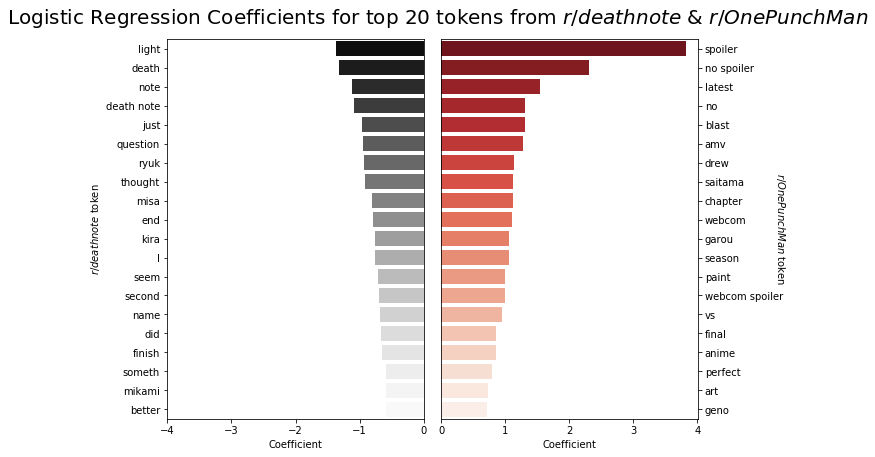

In [298]:
fig, axes = plt.subplots(ncols = 2, figsize=(10,6))
fig.suptitle(
    "Logistic Regression Coefficients for top 20 tokens from $\t{r/deathnote}$ & $\t{r/OnePunchMan}$", 
    y = 1.05,
    fontsize = 20
)
# deathnote coefficients (negative/black)
sns.barplot(
    ax = axes[0],
    y = coefs_dn.index, 
    x = coefs_dn,
    palette="Greys_r"
);

# customized x axis
axes[0].set_xlim((-4,0))
axes[0].set_xticks([i for i in range(-4,1)])
axes[0].set_xlabel("Coefficient")
axes[0].set_ylabel("$\t{r/deathnote}$ token")

# OnePunchMan coefficients (positive/red)
sns.barplot(
    ax = axes[1],
    y = coefs_opm.index, 
    x = coefs_opm,
    palette="Reds_r"
);

axes[1].set_xlabel("Coefficient")
axes[1].set_ylabel("$\t{r/OnePunchMan}$ token", rotation = -90)
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.set_ticks_position('right') # placing labels on opposite side
w = axes[1]
plt.tight_layout()

#### Content specific associations
Interestingly, we might expect the most telling tokens to come directly from the name of the associated anime shows. However we only see this with r/deathnote - "death note" as well as "death" and "note" separately. We do not see this trend with r/OnePunchMan. We might expect to see "one punch man", "one punch", or the abbreviation "opm" as a key feature, but we don't. 

We do see a clear similarity in that character names are quite important distinguishing factors:  

_Death Note characters:_ 
- Light or Kira (main protagonist), Ryuk, Misa, L (main protagonist), Mikami

_One Punch Man characters:_ 
- Blast, Saitama (main protagonist), Garou (main antagonist for the current season), Genos

For the most part, these findings are as expected - the name of the show and unique character names serve as red flags for the associated anime. 

#### Indirect associations
There are also some of __strong secondary associations found for One Punch Man__:

- "draw", "paint", and "art", refering to the (infamous) artistic style featured in the second season of the show.

<img src="assets/season1vs2.jpg" width="300px">

- "amv" is an acronym for "anime music video", is a fan-made music video consisting of clips from an animated show set to an audio track. While not unique to One Punch Man, the show is considerably more action packed, featuring intense fighting scenes which lends itself well to fan-made video content.
- "webcom", refering to the web comic, from which the show is based. Here, we see a distinction in the original content these shows came from. One Punch Man started as a web comic, while Death Note was originally a manga.
- "chapter" is similarly referring to the web comic format. 
- "vs", refering to the common format the show takes when pitting the main character against an assortment of enemies. For example: [Saitama vs. Genos](https://www.youtube.com/watch?v=km2OPUctni4)


#### Temporal associations
By far, the largest red flag was whether or not the word "spoiler" appeared in a title. By and large, a title with the word "spoiler" in it meant it most likely belonged to the One Punch Man subreddit. Here, we see this model heavily relies on temporal associations when predicting for r/OnePunchMan. For example, we see other temporal words associated with One Punch Man related to recency, such as: "latest" and "season (2)".

The One Punch Man anime is still active, having recently completing it's 2nd season. As such, reddit users are wary of spoiling the plot for the uninitiated and are careful to include warnings in the title of the post. 

Meanwhile, Death Note finished it's final season years ago, and few are concerned with spoiling it's plot. For example, we see temporal words associated with r/deathnote, such as: "end" and "finish". The term "question" also appears to be a strong indicator, which may be an indication of a fan-base reflecting on a finished show (we explore this phenomenon more later).

This component shows there are fairly strong temporal associations __directly related__ to when each anime was last active. The model's over reliance on the recency of One Punch Man episodes will likely make it less generalized to new data.

### Misc. words
We also see some tokens that have little explaination for their importance. In particular, the r/deathnote subreddit contains a number of these odd tokens.

Words such as "just", "seem", and "better" are highly associated with r/deathnote, but are not clearly connected with the show or its content.

_These may be considered stop words, as we did not use an exhaustive stop word list._

These words are likely left over artifacts from word association and will require a deeper look as to their origin.

### Exploring odd tokens highly indicative of r/deathnote

In [373]:
# https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook
def highlight_word(string, word):
    '''Replaces given word in string with red text'''
    return string.replace(word, f"\x1b[31m{word.upper()}\x1b[0m")

In [385]:
def highlight_word_of_interest(series, word, n = 10):
    '''For each string in the given pandas Series, prints the given word with highlight (red text)'''
    filtered_series = series[series.str.contains(word)]
    print(highlight_word(f"Highlighting word of interest: {word}", word))
    for i in range(min(n, len(filtered_series))):
        print(f"{i+1}. {highlight_word(filtered_series.iloc[i], word)}")

In [386]:
deathnote_titles = df[df["subreddit"] == 0]["title"]

In [387]:
highlight_word_of_interest(deathnote_titles,"just")

Highlighting word of interest: JUST
1. is it JUST me or doe the soundtrack seem similar to other soundtracks?
2. JUST finish death note
3. whi doe goth joker bend his knee and hunch his back when he flies? wouldn't it be easier to JUST dangl from his wing
4. JUST finish the show (spoiler)
5. i JUST watch and finish death note for the first time in my life
6. this is JUST to good not to be here.
7. (spoilers) i JUST realiz princ light is the princ shcneizel (from code geass) of death note, (spoiler for both animes)
8. le JUSTic has arriv
9. was the scene at 6:54 actual in death note? or JUST some veri well anim scene by a fan girl?
10. in episod 26 ear say he had been collect data on the kira case for 3 years. whi didn't he JUST get the inform from l when he die shouldn't that be part of the automat message?


The word "just" may serve as an associated word with "finish" - suggesting reddit users are yet again indicating the temporal gap between the series.

We do see "spoilers" in a number of the titles with "just", suggesting it may play a part in countering the strong pull "spoiler" has.

In [388]:
highlight_word_of_interest(deathnote_titles,"seem")

Highlighting word of interest: SEEM
1. is it just me or doe the soundtrack SEEM similar to other soundtracks?
2. this might SEEM stupid but... (spoilers!!)
3. nee death note one short SEEM to featur an angel
4. can't SEEM to find a larg chunk of the soundtrack online?
5. (spoiler) mani SEEM to like my previous render, so here anoth one inspir on the delet funer scene
6. mhhhhm... someth a littl SEEM off about this pictur but i can't put my finger on it. can anyon pin point what it is? i'm ask becaus i put effort into make this look accur yet i'm not quit satisfied.


Similarly, "seem" may play a role in countering the effect of "spoilers".


In [389]:
highlight_word_of_interest(deathnote_titles,"better")

Highlighting word of interest: BETTER
1. misa deserv so much BETTER than light
2. how much BETTER is the second half in the manga?
3. death note: anoth note. i think that bb was BETTER rival than light yagami
4. is light justifi in his attempt to creat a BETTER world by use the death note?
5. just rewatch the terribl netflix film and realiz that they could'v actual set some thing up BETTER. you guy mind take five min to check out my blog post?
6. you know what would have been a BETTER end to death note?
7. [spoilers] the second part: do you think it sucks, and why? is it BETTER in the manga?
8. which is BETTER?
9. BETTER than her
10. up vote if you like the manga BETTER and downvot if anime.


Its difficult to speculate exactly what makes "better" a strong indicator of death note. We suspect this is an artifact of word association. Character names and other related words like "manga" appear alongside "better".

### Interpreting model coefficients

Since logistic regression coefficients can be directly interpeted as the log of the odds of success (being from r/OnePunchMan), or, once exponentiated, as the odds of success.

$$\mu = \text{the odds of $y$ being in the category associated with 1, or success}$$

$$log(\mu) = \beta_0 + \beta_1X_1$$

$$\mu = e^{\beta_0 + \beta_1X_1}$$

As such, with every unit increase in $X_1$ we can say:
- A one unit increase in $X_1$ means the log-odds of success increases by $\beta_1$.  
- A one unit increase in $X_1$ means that success is $e^{\beta_1}$ times as likely  


In [344]:
# Top coefficients for r/OnePunchMan
coefs_df = pd.DataFrame({"$\\beta_1$":all_coefs, "$e^{\\beta_1}$" :np.exp(all_coefs)}, all_tokens)
coefs_df["$\\frac{1}{e^{\\beta_1}}$"] = 1 / coefs_df.iloc[:,1]
coefs_df.head()

,$\beta_1$,$e^{\beta_1}$,$\frac{1}{e^{\beta_1}}$
spoiler,3.82,45.604208,0.021928
no spoiler,2.31,10.074425,0.099261
latest,1.54,4.664590,0.214381
no,1.31,3.706174,0.269820
blast,1.31,3.706174,0.269820


We see that for every instance the word "spoiler" appears in a subreddit title of our dataset...:
- ...the log-odds of that observation being from r/OnePunchMan increases by $\beta_1$, or 3.82.  
- ...the odds of that observation being from r/OnePunchMan is $e^{\beta_1}$, or 45.6, times as likely as being from r/deathnote.


In [345]:
# Top coefficients for r/deathnote
coefs_df.tail()[::-1]

,$\beta_1$,$e^{\beta_1}$,$\frac{1}{e^{\beta_1}}$
light,-1.38,0.251579,3.974902
death,-1.32,0.267135,3.743421
note,-1.12,0.326280,3.064854
death note,-1.09,0.336216,2.974274
just,-0.97,0.379083,2.637944


We see that for every instance the word "light" appears in a subreddit title of our dataset...:
- ...the log-odds of that observation being from r/OnePunchMan _decreases_ by $\beta_1$, or 1.38.  
- ...the odds of that observation being from r/deathnote is $\frac{1}{e^{\beta_1}}$, or 4, times as likely as being from r/OnePunchMan.


### Investigating model missclassification
It's interesting to see exactly where the model fails as a way to potentially improve model performance, as well as explain possible issues with the data itself.

In [400]:
def find_missing_data_points(model, X, y):
    '''Returns a dataframe missclassified datapoints'''
    preds = model.predict(X)
    missing = preds != y
    return pd.DataFrame({
        "title": X[missing],
        "pred": preds[missing],
        "actual": y[missing]
    })

In [409]:
# using entire dataset to explore wrong predictions
missed = find_missing_data_points(model_cvec_multNB, X, y)
mapping = {
    1:"r/OnePunchMan",
    0:"r/deathnote"
}
missed["pred"]   = missed["pred"].map(mapping)
missed["actual"] = missed["actual"].map(mapping)

missed.iloc[::5,:] # just taking a quick sample

,title,pred,actual
5,look for a manga artist,r/OnePunchMan,r/deathnote
74,[spoilers] unpopular opinion,r/OnePunchMan,r/deathnote
159,"yes, but actual no.",r/OnePunchMan,r/deathnote
268,spoiler everywhere!!,r/OnePunchMan,r/deathnote
302,final i can bring justic,r/OnePunchMan,r/deathnote
407,season 2 predictions?,r/OnePunchMan,r/deathnote
461,parallel in game of throne (spoilers),r/OnePunchMan,r/deathnote
612,this might seem stupid but... (spoilers!!),r/OnePunchMan,r/deathnote
661,[spoilers] what the fffffff.......,r/OnePunchMan,r/deathnote
791,[spoilers] let make some fiction and debate.,r/OnePunchMan,r/deathnote


It's clear the word "spoiler" is highly correlated with the One Punch Man subreddit, however this word does appear in the Death Note subreddit as well. Its unsurprising then to see the model make a _tradeoff between capturing many true positives while making a few false positive predictions_.  

After further analysis (not shown):
- We see one pitfall of using man-made text - _mispellings_. There are a number of mispellings found in the subreddit titles associated with the false negative predictions. For example:
    - "Garo" should be "Garou", a character from One Punch Man.  
    - "fubiki" should be "fubuki", another character
    - "moomin rider" should be "mumen rider", another character
    - "sopilers" is also a mispelled "spoilers", the dominant feature 

__It would seem the main culprit behind many of the model's false negative predictions is human error.__

## Conclusion
- After assessing the data from both subreddits, it was clear there were distinguishing features present.  
- The data were cleaned by lowercasing all text, removing special characters and numbers, and removing the lowest impact stop words. Each word was also stemmed using SnowballStemmer (english).    
- A model baseline for accuracy was established by using the most frequent outcome, r/deathnote at ~61% accuracy.  
- Then, after fitting various combinations of vectorizers and models, a single model was selected, the CVEC + MultNB model.
- This selected model performed well, with a 97% accuracy on the testing dataset.

__Therefore, it is possible to thwart the hacker's actions! With ~97% accuracy, the swapped posts can successfully be assigned to their respective subreddits.__ 

## Assumptions
In order to arrive at this conclusion, a number of assumptions were made.
1. It was assummed removing casing, special characters and numbers would not have a significant effect on the result. It is possible some of these missing features could have played some role in helping to distinguish subreddits and improve accuracy.
2. The Naive Bayes model assumes features are independent and unrelated. However, this requirement is most certainly violated in this case, since language necessarily has order and rules associated with it.
3. After using the TfidfVectorizer (TFIDF) for a few models, we stopped including it in model experiments, assuming it was inferior to CVEC. It is possible if the TFIDF was used in all model combinations, an even more accurate model could have been discovered.
4. The starting data was slightly unbalanced, favoring r/deathnote. By keeping these classes unbalanced, it is assumed this imbalance will not affect the model, however it is possible some bias against r/OnePunchMan exists.

## Recommendations
This model has a high dependence on the temporal markers found in the One Punch Man subreddit. As such, we would not recommend using this model after the One Punch Man anime is out of season or has concluded. 

The issue over unbalanced classes could be rectified using bootstrapping as a means to "boost" the number of observations for the minority class (r/OnePunchMan).

We were surprised to find the best model to not be the VotingClassifier. However, we know ensemble models tend to require more fine-tuning and if we could go back and work on this problem again we might consider spending more time on ensemble models.

Another weakness of the selected predictive model is its lack of portability. The model will likely only work well on determining the r/deathnote and r/OnePunchMan subreddits at the time the data were collected. To better accomodate for more subreddits/classes, a larger number of subreddits would need consideration. With that said, the immediate issue of returning the subreddits to their intended state can be effectively addressed using the selected model.

## References
- [r/OnePunchMan](https://www.reddit.com/r/OnePunchMan/)
- [r/deathnote](https://www.reddit.com/r/deathnote/)
- [Reddit API Documentation](https://www.reddit.com/dev/api/)